In [7]:
import os
import json
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import datetime
from PIL import Image

In [8]:
# Dataset path
dataDir = '/data/ephemeral/home/taehan/level2-objectdetection-cv-18/EDSR-PyTorch/experiment/test/results-Demo'
annotation_path = '/data/ephemeral/home/taehan/level2-objectdetection-cv-18/EDSR-PyTorch/experiment/test/train_x2.json'
original_anno_path = '/data/ephemeral/home/dataset/train_0.json'

# saved path
subimgs_path = '/data/ephemeral/home/sr_dataset/subimages'
updated_annotation_path = '/data/ephemeral/home/sr_dataset/train_x2_SR_4images.json'

In [9]:
def update_annotations_for_subimage(annotations, subimg_info, img_id):
    updated_annotations = []
    x_offset, y_offset, subimg_width, subimg_height = subimg_info

    for ann in annotations:
        x, y, width, height = ann['bbox']

        # BBox가 subimg 영역과 겹치는지 확인
        if (x + width > x_offset and x < x_offset + subimg_width and
            y + height > y_offset and y < y_offset + subimg_height):
            
            # Update BBox coordinate
            new_x = max(x - x_offset, 0)
            new_y = max(y - y_offset, 0)
            width = min(width, x+width - x_offset)
            height = min(height, y+height - y_offset)

            updated_ann = ann.copy()
            updated_ann['bbox'] = [new_x, new_y, width, height]
            updated_ann['image_id'] = img_id
            updated_annotations.append(updated_ann)
    
    return updated_annotations

In [10]:
# Read annotation file
with open(annotation_path, 'r') as file:
    data = json.load(file)

# Define new images and annotations
new_images = []
new_annotations = []
new_img_id = max([img['id'] for img in data['images']]) + 1

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
/data/ephemeral/home/taehan/level2-objectdetection-cv-18/EDSR-PyTorch/experiment/test/results-Demo
train/1806


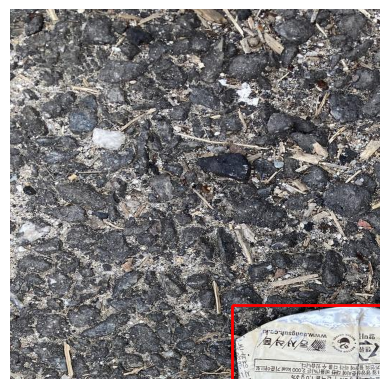

FileNotFoundError: [Errno 2] No such file or directory: '/data/ephemeral/home/sr_dataset/subimages/train/1806_0_x2_SR.png'

In [16]:
# Load images
coco = COCO(annotation_path)
for idx in os.listdir(dataDir):
    img = coco.loadImgs(int(idx.split('_')[0]))[0]
    img_file_name = img['file_name'].split('.')[0]
    print(dataDir)
    print(img_file_name)
    I = Image.open('{}/{}_x2_SR.png'.format(dataDir, img_file_name[-4:]))
    img_width, img_height = I.size

    # annotation ID
    annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns = coco.loadAnns(annIds)

    # 이미지를 4등분하는 영역 정의
    subimages = [
        (0, 0, img_width // 2, img_height // 2),  # 상단 왼쪽
        (img_width // 2, 0, img_width // 2, img_height // 2),  # 상단 오른쪽
        (0, img_height // 2, img_width // 2, img_height // 2),  # 하단 왼쪽
        (img_width // 2, img_height // 2, img_width // 2, img_height // 2)  # 하단 오른쪽
    ]

    # Update annotations for each partial image
    for i, subimg_info in enumerate(subimages):
        updated_anns = update_annotations_for_subimage(anns, subimg_info, new_img_id)

        # Draw X2 bounding box
        x_offset, y_offset, subimg_width, subimg_height = subimg_info
        subimg = I.crop((x_offset, y_offset, x_offset + subimg_width, y_offset + subimg_height))
        # plt.imshow(subimg)
        # plt.axis('off')
        
        # ax = plt.gca()
        # for ann in updated_anns:
        #     bbox = ann['bbox']
        #     rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
        #     ax.add_patch(rect)
        # plt.show()

        subimg_filename = '{}_{}_x2_SR.png'.format(img['file_name'].split('.')[0], i)
        # annotation file updated
        if updated_anns:
            new_img = {
                "width": subimg_width,
                "height": subimg_height,
                "file_name": subimg_filename,
                "license": 0,
                "flickr_url": None,
                "coco_url": None,
                "date_captured": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                "id": new_img_id
            }
            new_images.append(new_img)
            new_annotations.extend(updated_anns)

            # bbox가 있는 경우만 subimg 저장 
            subimg.save(os.path.join(subimgs_path, subimg_filename))
        
            new_img_id += 1

In [ ]:
# 추가는 train.json 파일로 해야함
with open(original_anno_path, 'r') as file:
    original_data = json.load(file)

original_data['images'].extend(new_images)
original_data['annotations'].extend(new_annotations)

with open(updated_annotation_path, 'w') as file:
    json.dump(original_data, file, indent=2)

In [3]:
# JSON 겹치는 부분 지우는 코드
import json

def remove_overlapping_annotations(train_0_path, train_x2_sr_path, output_path):
    # train_0.json 파일 읽기
    with open(train_0_path, 'r') as f:
        train_0_data = json.load(f)
    
    # train_x2_SR_4images.json 파일 읽기
    with open(train_x2_sr_path, 'r') as f:
        train_x2_sr_data = json.load(f)
    
    # train_x2_SR_4images.json에서 존재하는 image_id 및 annotation_id를 저장
    train_x2_sr_image_ids = {img['file_name'][6:10] for img in train_x2_sr_data['images']}
    train_x2_sr_annotation_ids = {ann['id'] for ann in train_x2_sr_data['annotations']}
    
    # train_0.json에서 겹치는 image_id 및 annotation_id 제거
    new_images = [img for img in train_0_data['images'] if img['id'] not in train_x2_sr_image_ids]
    new_annotations = [ann for ann in train_0_data['annotations'] if ann['id'] not in train_x2_sr_annotation_ids]
    
    # 제거된 이미지를 사용해 새로운 train_0 데이터 생성
    train_0_data['images'] = new_images
    train_0_data['annotations'] = new_annotations
    
    # 결과를 새로운 파일로 저장
    with open(output_path, 'w') as f:
        json.dump(train_0_data, f, indent=2)
    
    print(f"Overlapping images and annotations removed. Data saved to {output_path}")

def main():
    # 파일 경로 설정
    train_0_path = '/data/ephemeral/home/dataset/train_0.json'
    train_x2_sr_path = '/data/ephemeral/home/sr_dataset/train_x2_SR_4images.json'
    output_path = '/data/ephemeral/home/sr_dataset/cleaned_train_0.json'
    
    # 겹치는 부분 제거 후 저장
    remove_overlapping_annotations(train_x2_sr_path, train_0_path, output_path)

if __name__ == "__main__":
    main()


Overlapping images and annotations removed. Data saved to /data/ephemeral/home/sr_dataset/cleaned_train_0.json


In [6]:
# x2 json을 fold에 맞게 수정하는 코드
import json

def remove_non_overlapping_annotations(train_0_path, train_x2_sr_path, output_path):
    # train_0.json 파일 읽기
    with open(train_0_path, 'r') as f:
        train_0_data = json.load(f)
    
    # train_x2_SR_4images.json 파일 읽기
    with open(train_x2_sr_path, 'r') as f:
        train_x2_sr_data = json.load(f)
    
    # train_0.json에서 존재하는 file_name 추출
    train_0_filenames = {img['file_name'][6:10] for img in train_0_data['images']}
    
    # train_x2_SR_4images.json에서 file_name이 train_0.json에 없는 항목들을 필터링
    new_images = []
    new_annotations = []
    train_x2_sr_image_ids = set()
    
    # file_name이 train_0_filenames에 포함되지 않는 이미지 및 annotation 삭제
    for img in train_x2_sr_data['images']:
        if img['file_name'][6:10] in train_0_filenames:
            new_images.append(img)
            train_x2_sr_image_ids.add(img['id'])  # 해당 image_id 추가
    
    # 해당 image_id와 연결된 annotations만 유지
    for ann in train_x2_sr_data['annotations']:
        if ann['image_id'] in train_x2_sr_image_ids:
            new_annotations.append(ann)
    
    # 결과를 새로운 JSON 파일로 저장
    cleaned_data = {
        "images": new_images,
        "annotations": new_annotations,
        "categories": train_x2_sr_data['categories']  # categories 정보는 유지
    }
    
    with open(output_path, 'w') as f:
        json.dump(cleaned_data, f, indent=2)
    
    print(f"Non-overlapping images and annotations removed. Data saved to {output_path}")

def main():
    # 파일 경로 설정
    train_0_path = '/data/ephemeral/home/dataset/train_0.json'
    train_x2_sr_path = '/data/ephemeral/home/sr_dataset/cleaned_train_0.json'
    output_path = '/data/ephemeral/home/sr_dataset/filtered_train_0.json'
    
    # 중복되지 않는 부분 제거 후 저장
    remove_non_overlapping_annotations(train_0_path, train_x2_sr_path, output_path)

if __name__ == "__main__":
    main()


Non-overlapping images and annotations removed. Data saved to /data/ephemeral/home/sr_dataset/filtered_train_0.json
